In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from math import log 
from math import exp
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline

In [2]:
data = pd.read_csv("us-states.csv", parse_dates=True)

In [3]:
states = data['state'].unique()

In [4]:
# for one California
state = 'California'
cal_data = data[data.state == state].drop(['fips', 'deaths', 'state'], axis=1).set_index('date')
cal_data = pd.DataFrame(cal_data).set_index(pd.to_datetime(pd.DataFrame(cal_data).index)).squeeze()

In [5]:
# convert to new daily cases
previous = [x for x in cal_data[:]]
current = [x for x in cal_data[1:]]
new_daily_cases = [(current[i] - previous[i]) for i in range(len(current))]
cal_data[1:].index
cal_data_daily_case = pd.Series(new_daily_cases, index=cal_data[1:].index)

# Data Split

In [6]:
# predict next week of deaths
split = len(cal_data_daily_case) - 7
#for train-val, and test
train, test = cal_data_daily_case[0:split], cal_data_daily_case[split:]

In [7]:
print('Dataset %d, Validation %d' % (len(train), len(test))) 

Dataset 169, Validation 7


In [8]:
train.to_csv("train.csv", header=False)
test.to_csv("test.csv", header=False)

In [9]:
# for train - validation
train.astype('float32')
validation_split = int(len(train) * 0.50) 
X_train, X_val = train[0:validation_split], train[validation_split:] 

In [40]:
#walk-forward validation for persistence model(naive forecast)
history = [x for x in X_train] 
predictions = list() 
for i in range(len(X_val)):
    #predict
    yhat = history[-1]
    predictions.append(yhat)
    #observation
    obs = X_val[i]
    history.append(obs)
    
#measure performance
rmse = sqrt(mean_squared_error(X_val, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 818.615


RMSE of 818 using a naive forecast that just uses prediction from past day, would on average be off by 818 cases

# EDA 

In [11]:
train.describe()

count     169.000000
mean     1938.905325
std      2287.687937
min         0.000000
25%        15.000000
50%      1349.000000
75%      2515.000000
max      9897.000000
dtype: float64

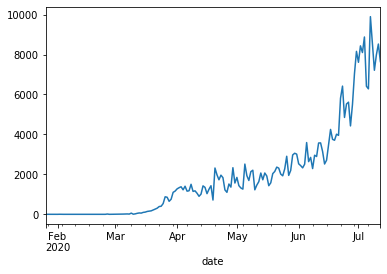

In [12]:
#line plot
train.plot()
plt.show()

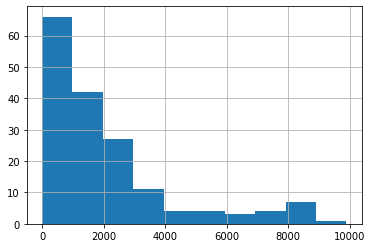

In [13]:
#histogram
train.hist()
plt.show()

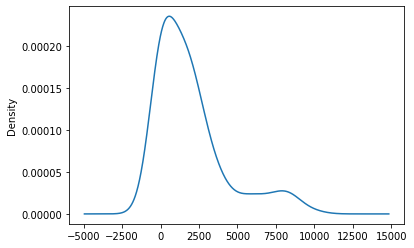

In [14]:
train.plot(kind='kde')
plt.show()

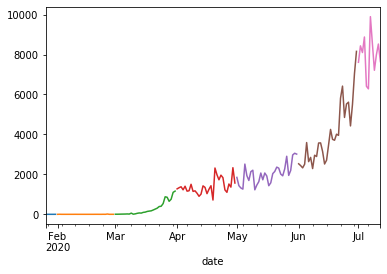

In [15]:
train.groupby(pd.Grouper(freq="M")).plot()
plt.show()

## Modeling

In [19]:
# check for stationarity on differenced dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return pd.Series(diff)

X = train.values

#difference data
stationary = difference(X)
stationary.index = train.index[1:] 

#check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items(): 
    print('\t%s: %.3f' % (key, value)) 

ADF Statistic: -2.425956
p-value: 0.134544
Critical Values:
	1%: -3.473
	5%: -2.880
	10%: -2.577


 reject the null hypothesis with a signiﬁcance level of greater than 10%
 the differenced dataset is stationary, with less than 90% confidence

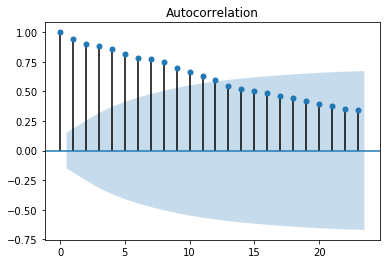

In [20]:
#autocorrelation
plot_acf(train)
plt.show()

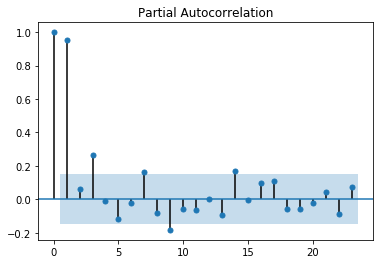

In [21]:
#partial autocorrelation
plot_pacf(train)
plt.show()

In [39]:
#test model parameters

#walk-forward validation for ARIMA model
history = [x for x in X_train] 
predictions = list() 
for i in range(len(X_val)):
    #predict
    model = ARIMA(history, order=(0,1,2))  #does not converge on nonzero values for AR parameters
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    #observation
    obs = X_val[i]
    history.append(obs)

rmse = sqrt(mean_squared_error(X_val, predictions)) 
print('RMSE: %.3f' % rmse)

RMSE: 761.058


# Grid Search

In [23]:
def evaluate_arima(train, val, arima_param):
    
    #walk-forward validation for ARIMA model
    history = [x for x in train] 
    predictions = list() 
    for i in range(len(val)):
        #predict
        model = ARIMA(history, order=arima_param)  #does not converge on nonzero values for AR parameters
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        #observation
        obs = X_val[i]
        history.append(obs)

    rmse = sqrt(mean_squared_error(val, predictions)) 
    return rmse

In [37]:
p_values = range(0,5)
d_values = range(0,4)
q_values = range(0,5)
best_score, best_config =  float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            ## many ARIMA configs will throw error if it does not converge, much handle these errors
            try:
                rmse = evaluate_arima(X_train, X_val, order)
                if rmse < best_score: 
                    best_score, best_config = rmse, order
                print('ARIMA%s RMSE=%.3f' % (order,rmse)) 
            except Exception as e:
                continue
                
warnings.filterwarnings("ignore")
print('Best ARIMA%s RMSE=%.3f' % (best_config, best_score))

ARIMA(0, 0, 1) RMSE=1893.152
ARIMA(0, 0, 2) RMSE=1474.693
ARIMA(0, 1, 1) RMSE=783.219
ARIMA(0, 1, 2) RMSE=761.058
ARIMA(0, 2, 1) RMSE=825.032
ARIMA(1, 0, 0) RMSE=830.105
ARIMA(1, 1, 0) RMSE=815.279
ARIMA(1, 1, 1) RMSE=770.934
ARIMA(1, 2, 0) RMSE=1182.732
ARIMA(2, 0, 0) RMSE=824.608
ARIMA(2, 1, 0) RMSE=759.880
ARIMA(2, 1, 1) RMSE=764.362
ARIMA(3, 0, 0) RMSE=774.425
ARIMA(3, 1, 0) RMSE=765.924
ARIMA(3, 1, 1) RMSE=770.301
ARIMA(3, 2, 0) RMSE=915.651
Best ARIMA(2, 1, 0) RMSE=759.880


# check residuals

In [25]:
#checking residuals(errors) should be Gaussian, if not this indicates the model can possibily be improved

history = [x for x in X_train] 
predictions = list() 
for i in range(len(X_val)):
    #predict
    model = ARIMA(history, order=best_config)  #does not converge on nonzero values for AR parameters
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    #observation
    obs = X_val[i]
    history.append(obs)
    
# errors 
residuals = [X_val[i]-predictions[i] for i in range(len(X_val))] 
residuals = pd.DataFrame(residuals)

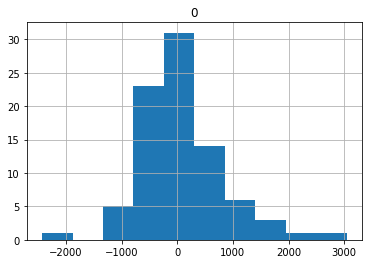

In [26]:
residuals.hist()
plt.gca()

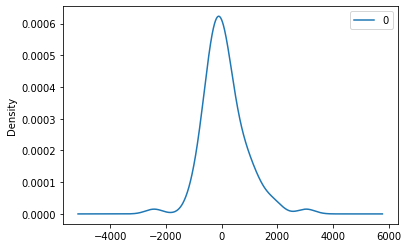

In [27]:
residuals.plot(kind='kde')
plt.gca()

slightly too skinny to be Gaussian

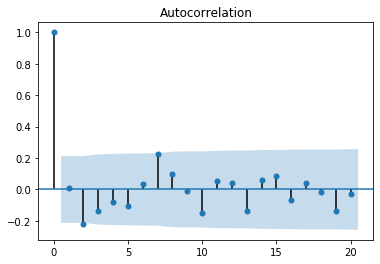

In [28]:
plot_acf(residuals)
plt.show()

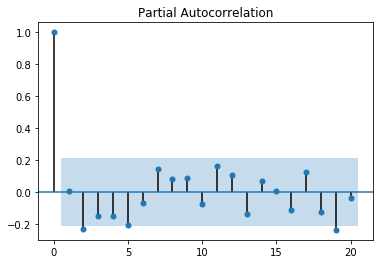

In [29]:
plot_pacf(residuals)
plt.show()

this shows that the auto correlation in the time series has been modeled correctly

# Data Transform

In [31]:
transformed, lam = boxcox([x+1 for x in train])

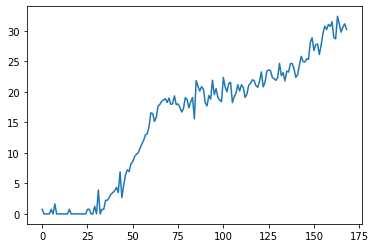

In [32]:
plt.plot(transformed)
plt.show()

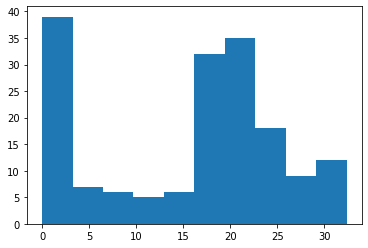

In [33]:
plt.hist(transformed)
plt.show()

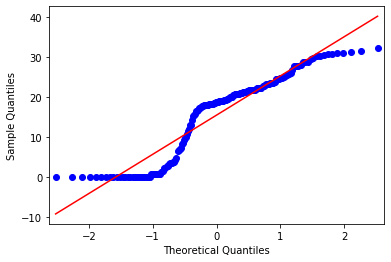

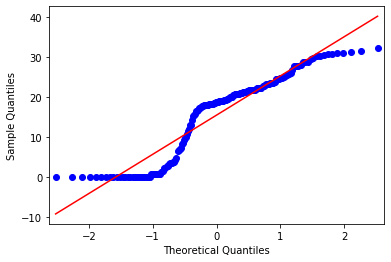

In [34]:
qqplot(transformed, line='r')

In [35]:
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

In [38]:
history = [x+1 for x in X_train] #to make nonzero
predictions = list() 

for i in range(len(X_val)):
    #transform
    transformed, lam = boxcox(history)
    # -5 < lambda < 5
    if lam < -5: 
        transformed, lam = history, 1 
    # predict 
    model = ARIMA(transformed, order=(2,1,0))
    model_fit = model.fit(disp=0) 
    yhat = model_fit.forecast()[0] 
    # invert transformed prediction
    yhat = boxcox_inverse(yhat, lam) 
    predictions.append(yhat)
    # observation 
    obs = X_val[i] 
    history.append(obs) 
    
rmse = sqrt(mean_squared_error(X_val, predictions)) 
print('RMSE: %.3f' % rmse)

RMSE: 778.909


it would seem that the best model would be the non-transformed ARIMA model found through Grid Search

# Test Validation

In [42]:
history = [x for x in train]
y = test.values.astype('float32')

predictions = list() 
for i in range(0, len(y)):
    # predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs)) 
    
    
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse) 

>Predicted=7777.790, Expected=8530.000
>Predicted=8699.452, Expected=10387.000
>Predicted=9518.687, Expected=8904.000
>Predicted=8637.855, Expected=9264.000
>Predicted=9896.148, Expected=10161.000
>Predicted=9795.046, Expected=8272.000
>Predicted=8638.285, Expected=8266.000
RMSE: 979.209


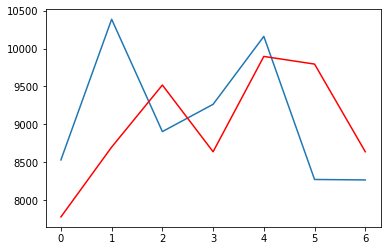

In [43]:
plt.plot(y) 
plt.plot(predictions, color='red') 
plt.show()

Model performs a bit worse on test data than validation. Univariate time series with only one variable, and a highly non-stationary series with non-Gaussian distributed values. Transforms did not seem to help much. Could possibly use a LSTM model instead. also possibly fitting a polynomial function to remove the trend directly from the dataset may help the model.